In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten
from keras.layers import SimpleRNN, LSTM, GRU

In [2]:
tf.random.set_seed(1)

In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
airline_passengers_data = pd.read_csv('airline-passengers.csv')

In [5]:
airline_passengers_data.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [9]:
airline_passengers_data['Month'] = pd.to_datetime(airline_passengers_data['Month'], format='%Y-%m')

In [10]:
def parse_date(df, date_feature_name):
    date_list = df[date_feature_name]
    years = []
    months = []
    for el in date_list:
        years.append(el.year)
        months.append(el.month)
    df['year'] = years
    df['mon'] = months

    return df

In [11]:
airline_passengers_data = parse_date(airline_passengers_data, 'Month')

In [12]:
data = airline_passengers_data.iloc[:, 1:]
data.head()

,Passengers,year,mon
0,112,1949,1
1,118,1949,2
2,132,1949,3
3,129,1949,4
4,121,1949,5


In [13]:
train_size = 100


# список признаков, по которым будем учить
features = ['Passengers', 'year', 'mon']


# отступ теста от тренировки
bias = 5


# делим
train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 3), (39, 3))

In [14]:
features = train_data.columns[1:]
target = train_data.columns[0]

In [15]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,year,mon
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


In [25]:

x_len = 3

future = 1

learning_rate = 0.003
batch_size = 8
epochs = 8

In [26]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

4 104
35 109


In [27]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (35, 2), (35,))

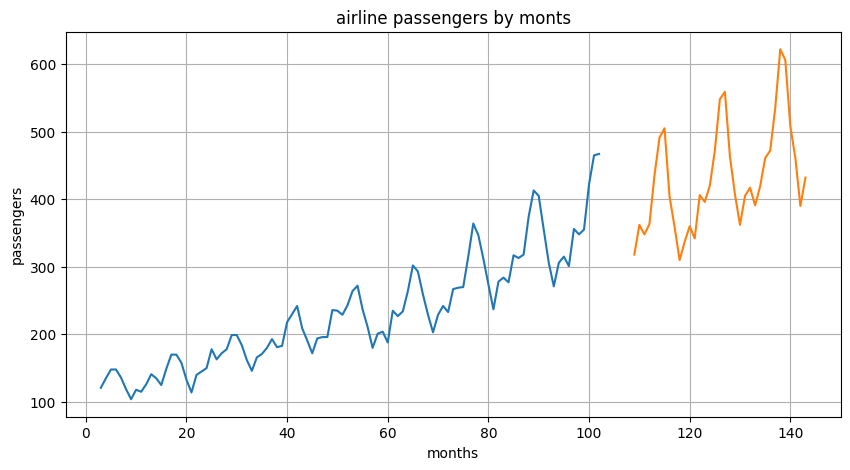

In [28]:
plt.figure(figsize=(10, 5))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by monts')
plt.show()

In [29]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [30]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]], shape=(3, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(135, shape=(), dtype=int64)


In [31]:
results = pd.DataFrame() 
model = [] 
train_m = [] 
test_m = [] 

In [32]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_1 = Sequential()

model_1.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 1, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(3, activation='linear'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 3, 32)             1120      
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 11687 (45.65 KB)
Trainable params: 11687

In [33]:
history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/8
13/13 [==============================] - 5s 57ms/step - loss: 57081.3438 - mae: 226.2522 - val_loss: 195428.2812 - val_mae: 434.7675
Epoch 2/8
13/13 [==============================] - 0s 20ms/step - loss: 56431.3555 - mae: 224.8872 - val_loss: 193020.1094 - val_mae: 432.0659
Epoch 3/8
13/13 [==============================] - 0s 21ms/step - loss: 56045.7969 - mae: 224.4238 - val_loss: 190170.3281 - val_mae: 428.8609
Epoch 4/8
13/13 [==============================] - 0s 18ms/step - loss: 55244.5195 - mae: 223.2484 - val_loss: 184533.5312 - val_mae: 422.4476
Epoch 5/8
13/13 [==============================] - 0s 18ms/step - loss: 53170.0508 - mae: 219.9135 - val_loss: 171278.5312 - val_mae: 406.9051
Epoch 6/8
13/13 [==============================] - 0s 17ms/step - loss: 47718.3359 - mae: 210.1941 - val_loss: 140958.3906 - val_mae: 368.6257
Epoch 7/8
13/13 [==============================] - 0s 18ms/step - loss: 35089.8242 - mae: 182.7893 - val_loss: 84216.8203 - val_mae: 282.6228


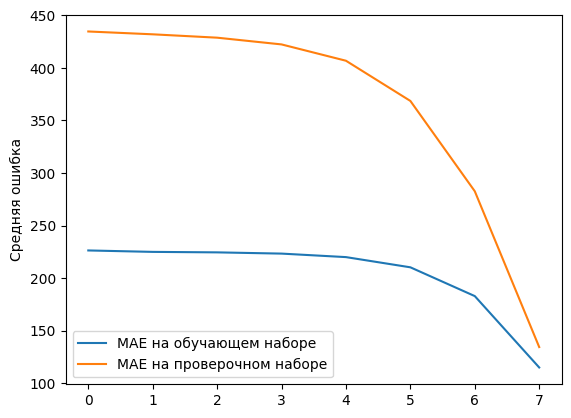

In [34]:
plt.plot(history_1.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [35]:
hist_val_1 = history_1.history['val_mae']
hist_train_1 = history_1.history['mae']

In [36]:
num_iterations = 25

Epoch 1/8
 1/13 [=>............................] - ETA: 0s - loss: 8017.4912 - mae: 82.4720

13/13 [==============================] - 0s 24ms/step - loss: 4661.8188 - mae: 55.2734 - val_loss: 7162.4941 - val_mae: 66.1374
Epoch 2/8
13/13 [==============================] - 0s 23ms/step - loss: 1815.7285 - mae: 34.3377 - val_loss: 16060.5889 - val_mae: 107.8375
Epoch 3/8
13/13 [==============================] - 0s 29ms/step - loss: 1246.0920 - mae: 27.3893 - val_loss: 15569.1113 - val_mae: 106.4472
Epoch 4/8
13/13 [==============================] - 0s 29ms/step - loss: 1185.8958 - mae: 26.8233 - val_loss: 12384.4160 - val_mae: 92.3846
Epoch 5/8
13/13 [==============================] - 0s 22ms/step - loss: 1185.1375 - mae: 27.1864 - val_loss: 12863.6406 - val_mae: 94.9639
Epoch 6/8
13/13 [==============================] - 0s 23ms/step - loss: 1121.9426 - mae: 26.5493 - val_loss: 12756.5498 - val_mae: 94.5170
Epoch 1/8
13/13 [==============================] - 0s 25ms/step - loss: 1094.3253 - mae: 26.1862 - val_loss: 12340.5225 - val_mae: 92.7096
Epoch 2/8
13/13 [===================

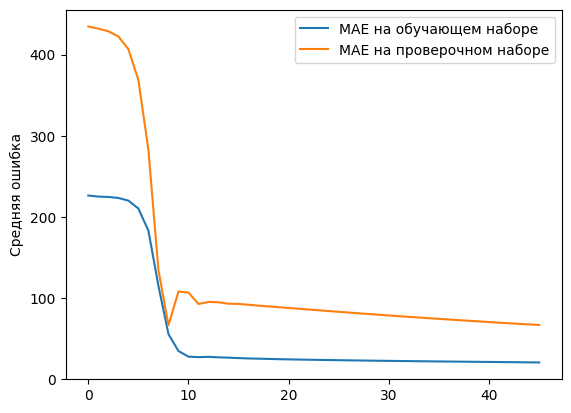

Epoch 1/8
13/13 [==============================] - 0s 18ms/step - loss: 632.4483 - mae: 20.0900 - val_loss: 6903.1943 - val_mae: 65.8745
Epoch 2/8
13/13 [==============================] - 0s 20ms/step - loss: 622.2572 - mae: 19.9314 - val_loss: 6785.5088 - val_mae: 65.1965
Epoch 3/8
13/13 [==============================] - 0s 17ms/step - loss: 611.6994 - mae: 19.7639 - val_loss: 6668.5850 - val_mae: 64.5130
Epoch 4/8
13/13 [==============================] - 0s 17ms/step - loss: 600.7441 - mae: 19.5867 - val_loss: 6552.1826 - val_mae: 63.8228
Epoch 5/8
13/13 [==============================] - 0s 16ms/step - loss: 589.3609 - mae: 19.3987 - val_loss: 6436.1162 - val_mae: 63.1419
Epoch 6/8
13/13 [==============================] - 0s 18ms/step - loss: 577.5240 - mae: 19.1991 - val_loss: 6320.1758 - val_mae: 62.4843
Epoch 7/8
13/13 [==============================] - 0s 18ms/step - loss: 565.2127 - mae: 18.9871 - val_loss: 6204.1958 - val_mae: 61.8187
Epoch 8/8
13/13 [========================

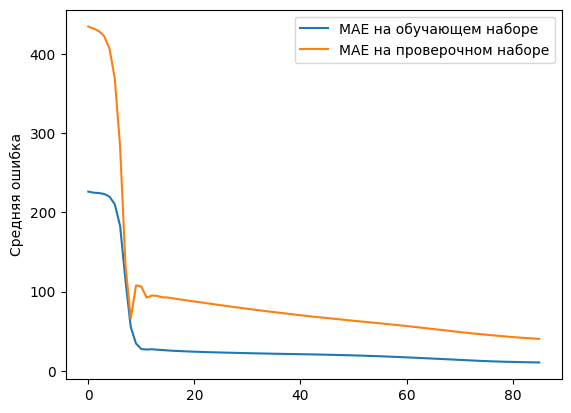

Epoch 1/8
13/13 [==============================] - 0s 17ms/step - loss: 175.7921 - mae: 10.3387 - val_loss: 2975.2266 - val_mae: 39.9140
Epoch 2/8
13/13 [==============================] - 0s 19ms/step - loss: 172.0678 - mae: 10.2528 - val_loss: 2929.6155 - val_mae: 39.5359
Epoch 3/8
13/13 [==============================] - 0s 19ms/step - loss: 168.5836 - mae: 10.1677 - val_loss: 2886.2703 - val_mae: 39.1970
Epoch 4/8
13/13 [==============================] - 0s 21ms/step - loss: 165.3140 - mae: 10.0809 - val_loss: 2845.0420 - val_mae: 38.8663
Epoch 5/8
13/13 [==============================] - 0s 20ms/step - loss: 162.2337 - mae: 9.9973 - val_loss: 2805.6641 - val_mae: 38.5427
Epoch 6/8
13/13 [==============================] - 0s 19ms/step - loss: 159.3258 - mae: 9.9180 - val_loss: 2768.0359 - val_mae: 38.2261
Epoch 7/8
13/13 [==============================] - 0s 19ms/step - loss: 156.5691 - mae: 9.8486 - val_loss: 2731.8689 - val_mae: 37.9151
Epoch 8/8
13/13 [===========================

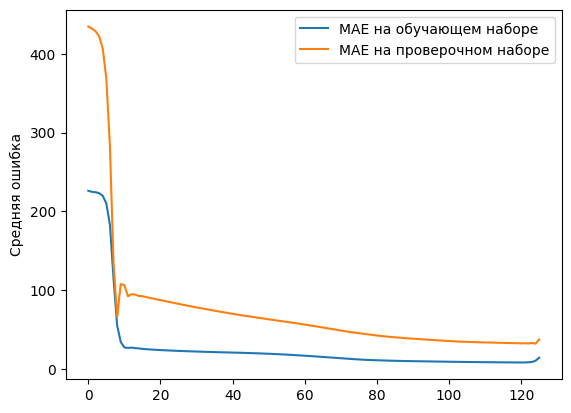

Epoch 1/8
13/13 [==============================] - 0s 30ms/step - loss: 716.8964 - mae: 19.3064 - val_loss: 1772.1313 - val_mae: 35.1630
Epoch 2/8
13/13 [==============================] - 0s 25ms/step - loss: 1618.2468 - mae: 30.5454 - val_loss: 4608.4434 - val_mae: 51.0729
Epoch 3/8
13/13 [==============================] - 0s 25ms/step - loss: 2497.6216 - mae: 38.2438 - val_loss: 1602.4213 - val_mae: 30.6390
Epoch 4/8
13/13 [==============================] - 0s 24ms/step - loss: 1777.7954 - mae: 36.7800 - val_loss: 2571.7417 - val_mae: 36.1498
Epoch 5/8
13/13 [==============================] - 0s 24ms/step - loss: 1020.6525 - mae: 26.2652 - val_loss: 3860.7107 - val_mae: 45.8095
Epoch 6/8
13/13 [==============================] - 1s 47ms/step - loss: 1305.1990 - mae: 32.1784 - val_loss: 2273.1611 - val_mae: 35.3212
Epoch 7/8
13/13 [==============================] - 0s 29ms/step - loss: 1305.1035 - mae: 31.7046 - val_loss: 2207.0535 - val_mae: 34.0924
Epoch 8/8
13/13 [==================

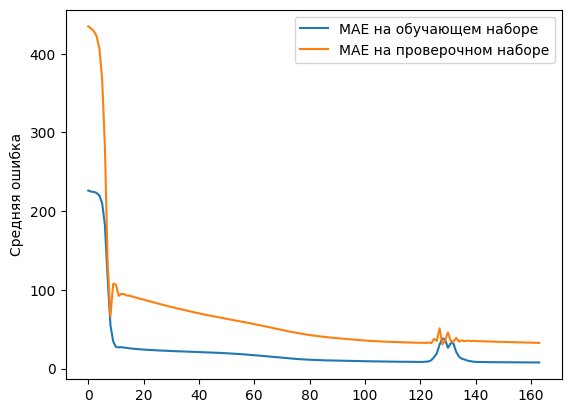

Epoch 1/8
13/13 [==============================] - 0s 20ms/step - loss: 100.0665 - mae: 7.6439 - val_loss: 1965.5010 - val_mae: 32.4940
Epoch 2/8
13/13 [==============================] - 0s 18ms/step - loss: 99.7202 - mae: 7.6280 - val_loss: 1949.1569 - val_mae: 32.3971
Epoch 3/8
13/13 [==============================] - 0s 19ms/step - loss: 99.3895 - mae: 7.6065 - val_loss: 1934.2402 - val_mae: 32.3263
Epoch 4/8
13/13 [==============================] - 0s 19ms/step - loss: 99.0564 - mae: 7.5907 - val_loss: 1918.3778 - val_mae: 32.2448
Epoch 5/8
13/13 [==============================] - 0s 25ms/step - loss: 98.7395 - mae: 7.5715 - val_loss: 1903.6365 - val_mae: 32.1745
Epoch 6/8
13/13 [==============================] - 0s 21ms/step - loss: 98.4266 - mae: 7.5524 - val_loss: 1889.0271 - val_mae: 32.1055
Epoch 7/8
13/13 [==============================] - 0s 21ms/step - loss: 98.1208 - mae: 7.5373 - val_loss: 1873.9083 - val_mae: 32.0298
Epoch 8/8
13/13 [==============================] - 0s 

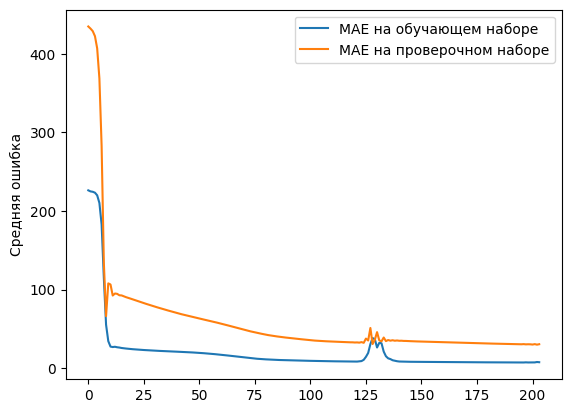

In [37]:
for iteration in range(num_iterations):
  history_1 = model_1.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_1.extend(history_1.history['val_mae'][:])
  hist_train_1.extend(history_1.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_1, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_1, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [38]:
pred_1 = model_1.predict(dataset_train).flatten()
pred_val_1 = model_1.predict(dataset_val).flatten()

5/5 [==============================] - 0s 3ms/step


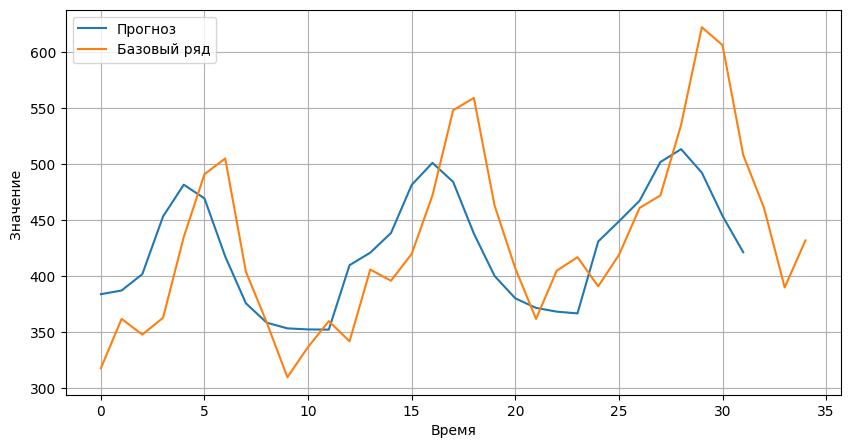

In [39]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

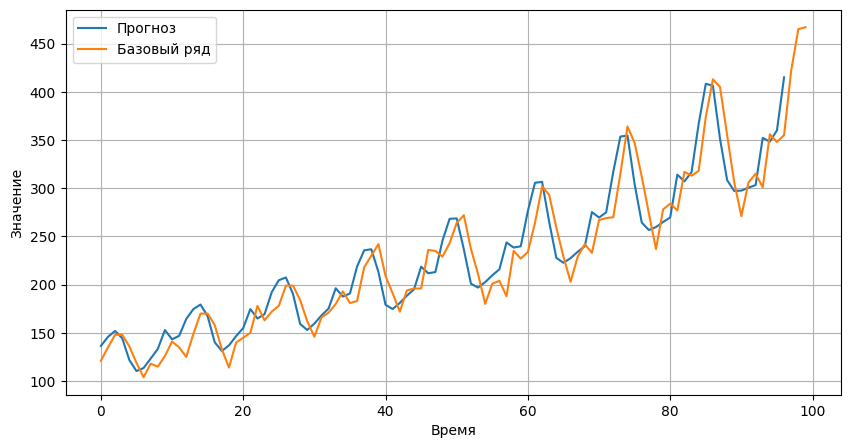

In [40]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [41]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_val)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')

model.append('SimpleRNN')
train_m.append(round(train_m_1,2))
test_m.append(round(test_m_1,2))

5/5 [==============================] - 0s 3ms/step - loss: 1614.6182 - mae: 30.4201
train_loss: 92.54397583007812, train_m: 7.534212112426758
test_loss: 1614.6181640625, test_m: 30.420135498046875


In [42]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_2 = Sequential()

model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4480      
                                                                 
 lstm_1 (LSTM)               (None, 3, 32)             8320      
                                                                 
 conv1d_4 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
 dense_5 (Dense)             (None, 1)                

In [43]:
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/8


13/13 [==============================] - 12s 170ms/step - loss: 56673.9961 - mae: 225.6707 - val_loss: 193153.1562 - val_mae: 432.1736
Epoch 2/8
13/13 [==============================] - 0s 22ms/step - loss: 56497.8438 - mae: 225.2977 - val_loss: 192634.7344 - val_mae: 431.5795
Epoch 3/8
13/13 [==============================] - 0s 23ms/step - loss: 55984.2539 - mae: 224.2678 - val_loss: 190744.2812 - val_mae: 429.4189
Epoch 4/8
13/13 [==============================] - 0s 23ms/step - loss: 54104.3789 - mae: 220.5154 - val_loss: 183181.5000 - val_mae: 420.7061
Epoch 5/8
13/13 [==============================] - 0s 30ms/step - loss: 47580.7969 - mae: 207.0957 - val_loss: 155820.1719 - val_mae: 387.6420
Epoch 6/8
13/13 [==============================] - 0s 29ms/step - loss: 28912.7227 - mae: 162.1368 - val_loss: 81115.9766 - val_mae: 277.4739
Epoch 7/8
13/13 [==============================] - 0s 23ms/step - loss: 3346.2446 - mae: 50.8089 - val_loss: 7776.7070 - val_mae: 73.5997
Epoch 8/8
13/

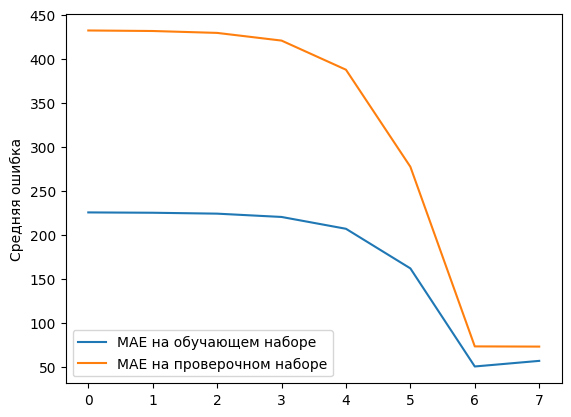

In [44]:
plt.plot(history_2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [45]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [46]:
num_iterations = 25

Epoch 1/8
 1/13 [=>............................] - ETA: 0s - loss: 1917.8972 - mae: 36.2094

13/13 [==============================] - 0s 26ms/step - loss: 1391.0895 - mae: 28.3073 - val_loss: 8317.6279 - val_mae: 70.6360
Epoch 2/8
13/13 [==============================] - 0s 25ms/step - loss: 738.1322 - mae: 21.2310 - val_loss: 4531.7837 - val_mae: 49.2203
Epoch 3/8
13/13 [==============================] - 0s 28ms/step - loss: 723.6724 - mae: 20.7351 - val_loss: 5043.5166 - val_mae: 51.9400
Epoch 4/8
13/13 [==============================] - 0s 28ms/step - loss: 699.3757 - mae: 20.4924 - val_loss: 4957.2578 - val_mae: 51.5373
Epoch 5/8
13/13 [==============================] - 0s 28ms/step - loss: 700.6248 - mae: 20.5273 - val_loss: 4707.5562 - val_mae: 50.1680
Epoch 6/8
13/13 [==============================] - 0s 30ms/step - loss: 686.0994 - mae: 20.1783 - val_loss: 4827.3652 - val_mae: 50.9452
Epoch 7/8
13/13 [==============================] - 0s 26ms/step - loss: 682.0596 - mae: 20.1430 - val_loss: 4695.2563 - val_mae: 50.2020
Epoch 1/8
13/13 [==============================] -

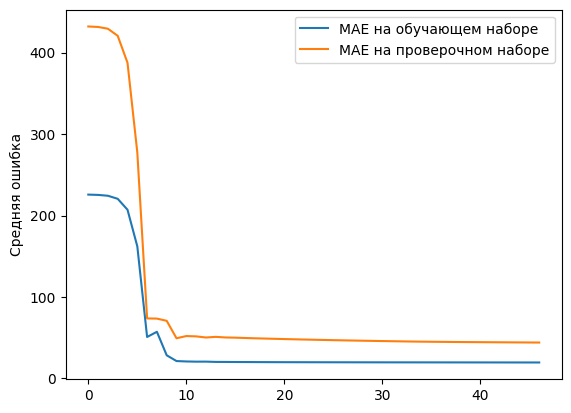

Epoch 1/8
13/13 [==============================] - 0s 23ms/step - loss: 621.1085 - mae: 19.4729 - val_loss: 3564.2590 - val_mae: 43.8854
Epoch 2/8
13/13 [==============================] - 0s 22ms/step - loss: 620.1249 - mae: 19.4652 - val_loss: 3547.1091 - val_mae: 43.8071
Epoch 3/8
13/13 [==============================] - 0s 26ms/step - loss: 619.1403 - mae: 19.4585 - val_loss: 3530.1558 - val_mae: 43.7309
Epoch 4/8
13/13 [==============================] - 0s 22ms/step - loss: 618.1534 - mae: 19.4513 - val_loss: 3513.3574 - val_mae: 43.6695
Epoch 5/8
13/13 [==============================] - 0s 25ms/step - loss: 617.1623 - mae: 19.4435 - val_loss: 3496.7007 - val_mae: 43.6070
Epoch 6/8
13/13 [==============================] - 0s 27ms/step - loss: 616.1661 - mae: 19.4352 - val_loss: 3480.1418 - val_mae: 43.5433
Epoch 7/8
13/13 [==============================] - 0s 26ms/step - loss: 615.1624 - mae: 19.4263 - val_loss: 3463.6650 - val_mae: 43.4784
Epoch 8/8
13/13 [========================

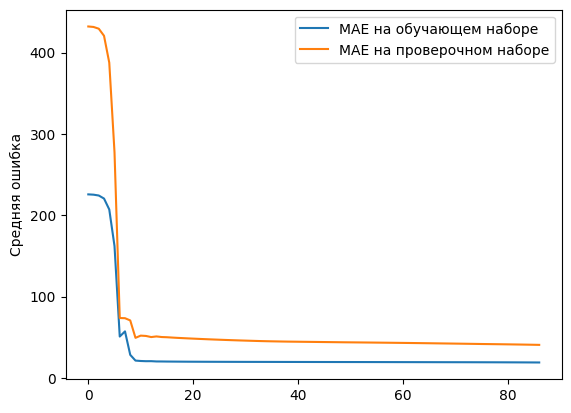

Epoch 1/8
13/13 [==============================] - 1s 48ms/step - loss: 562.7291 - mae: 18.8733 - val_loss: 2855.9778 - val_mae: 40.4382
Epoch 2/8
13/13 [==============================] - 1s 39ms/step - loss: 559.8589 - mae: 18.8318 - val_loss: 2834.2190 - val_mae: 40.3046
Epoch 3/8
13/13 [==============================] - 1s 39ms/step - loss: 556.8241 - mae: 18.7867 - val_loss: 2811.9690 - val_mae: 40.1637
Epoch 4/8
13/13 [==============================] - 0s 35ms/step - loss: 553.6116 - mae: 18.7377 - val_loss: 2789.1780 - val_mae: 40.0146
Epoch 5/8
13/13 [==============================] - 1s 63ms/step - loss: 550.2055 - mae: 18.6845 - val_loss: 2765.7976 - val_mae: 39.8569
Epoch 6/8
13/13 [==============================] - 1s 51ms/step - loss: 546.5900 - mae: 18.6267 - val_loss: 2741.7622 - val_mae: 39.6897
Epoch 7/8
13/13 [==============================] - 1s 41ms/step - loss: 542.7466 - mae: 18.5682 - val_loss: 2717.0151 - val_mae: 39.5122
Epoch 8/8
13/13 [========================

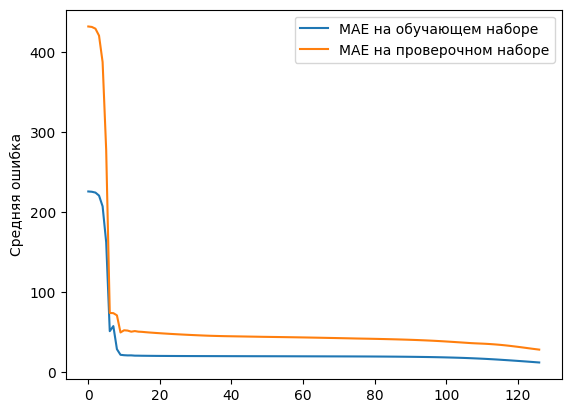

Epoch 1/8
13/13 [==============================] - 0s 28ms/step - loss: 192.2919 - mae: 11.3119 - val_loss: 1161.4744 - val_mae: 27.1854
Epoch 2/8
13/13 [==============================] - 0s 25ms/step - loss: 183.7971 - mae: 11.0083 - val_loss: 1121.3712 - val_mae: 26.7082
Epoch 3/8
13/13 [==============================] - 0s 38ms/step - loss: 176.2775 - mae: 10.7285 - val_loss: 1084.8031 - val_mae: 26.3211
Epoch 4/8
13/13 [==============================] - 1s 43ms/step - loss: 169.6957 - mae: 10.4960 - val_loss: 1051.7390 - val_mae: 25.9761
Epoch 5/8
13/13 [==============================] - 0s 37ms/step - loss: 163.9962 - mae: 10.2749 - val_loss: 1022.0765 - val_mae: 25.6780
Epoch 6/8
13/13 [==============================] - 0s 33ms/step - loss: 159.1120 - mae: 10.0757 - val_loss: 995.6396 - val_mae: 25.3930
Epoch 7/8
13/13 [==============================] - 0s 31ms/step - loss: 154.9625 - mae: 9.8870 - val_loss: 972.2283 - val_mae: 25.1219
Epoch 8/8
13/13 [===========================

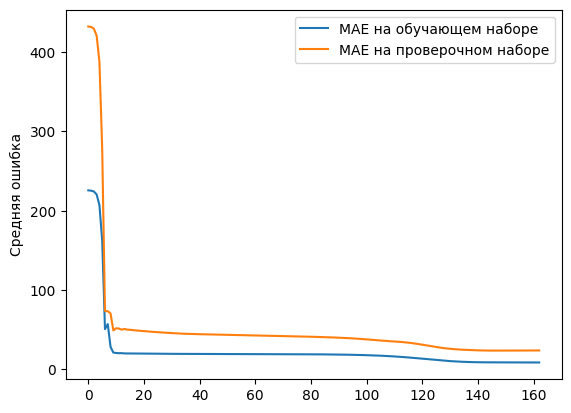

Epoch 1/8
13/13 [==============================] - 0s 29ms/step - loss: 130.1065 - mae: 8.7682 - val_loss: 840.7803 - val_mae: 23.9487
Epoch 2/8
13/13 [==============================] - 0s 28ms/step - loss: 129.8865 - mae: 8.7628 - val_loss: 842.6688 - val_mae: 23.9679
Epoch 3/8
13/13 [==============================] - 0s 29ms/step - loss: 129.6794 - mae: 8.7572 - val_loss: 844.5779 - val_mae: 23.9942
Epoch 4/8
13/13 [==============================] - 0s 28ms/step - loss: 129.4809 - mae: 8.7511 - val_loss: 846.5184 - val_mae: 24.0219
Epoch 5/8
13/13 [==============================] - 0s 33ms/step - loss: 129.2793 - mae: 8.7452 - val_loss: 848.6536 - val_mae: 24.0644
Epoch 6/8
13/13 [==============================] - 0s 31ms/step - loss: 129.0752 - mae: 8.7398 - val_loss: 851.0438 - val_mae: 24.1136
Epoch 1/8
13/13 [==============================] - 0s 37ms/step - loss: 128.8808 - mae: 8.7347 - val_loss: 853.5153 - val_mae: 24.1781
Epoch 2/8
13/13 [==============================] - 0s 2

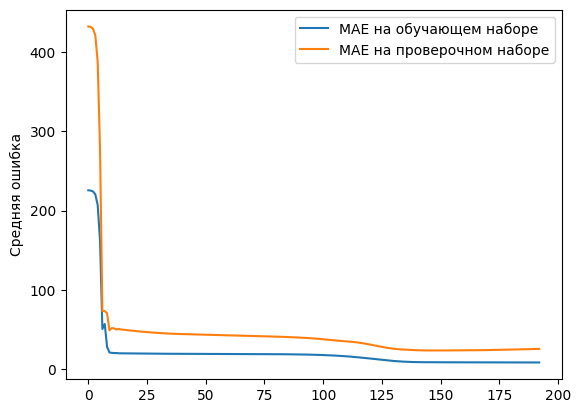

In [47]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [48]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

5/5 [==============================] - 0s 6ms/step


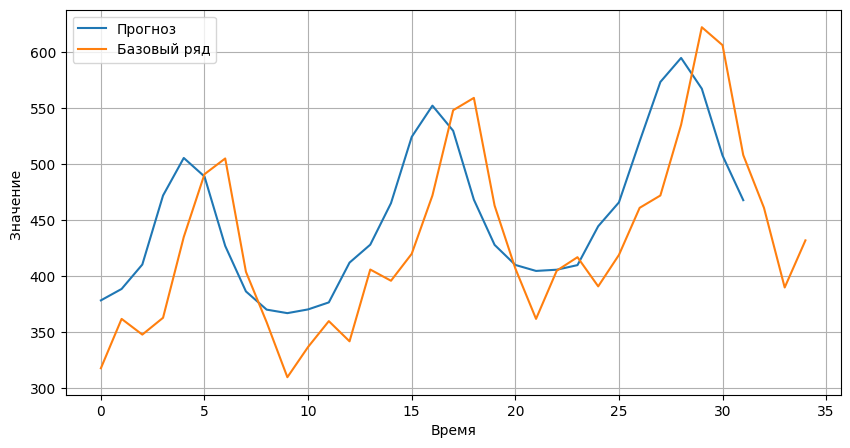

In [49]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

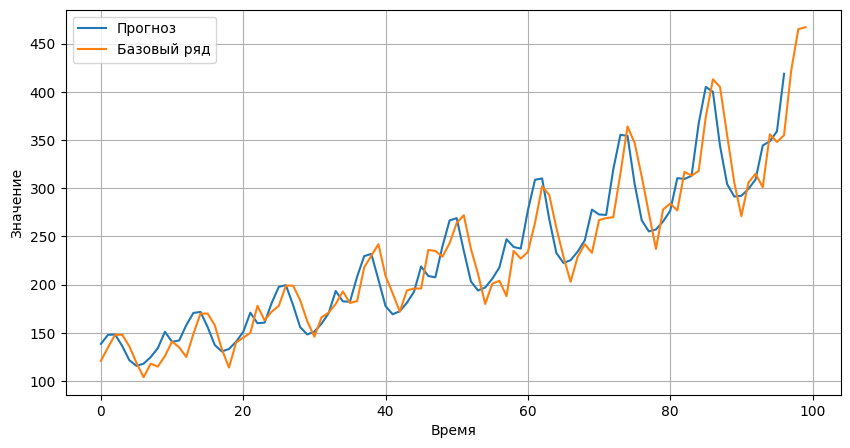

In [50]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [51]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_val)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

 1/13 [=>............................] - ETA: 1s - loss: 23.4578 - mae: 3.0118

5/5 [==============================] - 0s 6ms/step - loss: 924.8646 - mae: 25.6729
train_loss: 103.23821258544922, train_m: 7.849674701690674
test_loss: 924.8645629882812, test_m: 25.672945022583008


In [52]:
# установка ряда метапареметров  для нейронной сети и процесса тренировки
batch_size = 8
hidden_size = 32
num_iterations = 25 
num_epochs = 1
num_preds = 100

In [53]:
model_3 = Sequential()
model_3.add(
    GRU(
        hidden_size,
        return_sequences=True,
        input_shape=(inputs.shape[1], inputs.shape[2])
    )
)
model_3.add(Conv1D(64, 3, activation='linear'))
model_3.add(Conv1D(64, 1, activation='linear'))
model_3.add(Flatten())
model_3.add(Dense(3, activation='linear'))
model_3.add(Dense(1, activation='linear'))

model_3.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 32)             3456      
                                                                 
 conv1d_6 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_7 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_3 (Flatten)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 3)                 195       
                                                                 
 dense_7 (Dense)             (None, 1)                 4         
                                                                 
Total params: 14023 (54.78 KB)
Trainable params: 14023

In [54]:
history_3 = model_3.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/8


13/13 [==============================] - 13s 222ms/step - loss: 56816.2148 - mae: 225.8197 - val_loss: 194418.2344 - val_mae: 433.6086
Epoch 2/8
13/13 [==============================] - 0s 31ms/step - loss: 56388.2695 - mae: 224.9106 - val_loss: 192816.4688 - val_mae: 431.8123
Epoch 3/8
13/13 [==============================] - 0s 27ms/step - loss: 55883.0859 - mae: 224.0392 - val_loss: 190128.5625 - val_mae: 428.7900
Epoch 4/8
13/13 [==============================] - 0s 28ms/step - loss: 54543.5391 - mae: 221.5865 - val_loss: 183328.2656 - val_mae: 421.0265
Epoch 5/8
13/13 [==============================] - 0s 32ms/step - loss: 50657.8008 - mae: 214.1135 - val_loss: 164853.1406 - val_mae: 399.0720
Epoch 6/8
13/13 [==============================] - 0s 28ms/step - loss: 40048.6445 - mae: 191.5589 - val_loss: 119000.3828 - val_mae: 338.1352
Epoch 7/8
13/13 [==============================] - 0s 28ms/step - loss: 17563.5684 - mae: 127.6010 - val_loss: 38243.7227 - val_mae: 186.1716
Epoch 8/

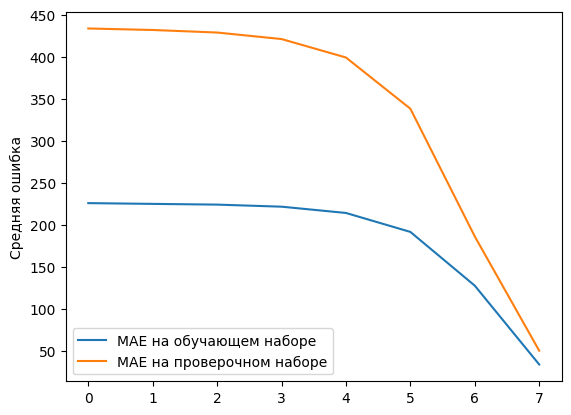

In [55]:
plt.plot(history_3.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_3.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [56]:
hist_val_3 = history_3.history['val_mae']
hist_train_3 = history_3.history['mae']

Epoch 1/8
 1/13 [=>............................] - ETA: 0s - loss: 4160.3608 - mae: 57.2132

13/13 [==============================] - 0s 25ms/step - loss: 2349.3516 - mae: 38.7469 - val_loss: 8784.5830 - val_mae: 74.8617
Epoch 2/8
13/13 [==============================] - 0s 20ms/step - loss: 840.6213 - mae: 22.9353 - val_loss: 7181.6729 - val_mae: 63.6517
Epoch 3/8
13/13 [==============================] - 0s 22ms/step - loss: 752.3925 - mae: 21.9092 - val_loss: 5198.9487 - val_mae: 52.1839
Epoch 4/8
13/13 [==============================] - 0s 24ms/step - loss: 692.4644 - mae: 20.5778 - val_loss: 5915.3608 - val_mae: 56.3474
Epoch 5/8
13/13 [==============================] - 0s 23ms/step - loss: 686.3333 - mae: 20.6438 - val_loss: 5594.7100 - val_mae: 54.5485
Epoch 6/8
13/13 [==============================] - 0s 21ms/step - loss: 690.9825 - mae: 20.7416 - val_loss: 5510.2983 - val_mae: 54.1106
Epoch 7/8
13/13 [==============================] - 0s 26ms/step - loss: 677.6117 - mae: 20.5101 - val_loss: 5562.2676 - val_mae: 54.4708
Epoch 8/8
13/13 [==============================] -

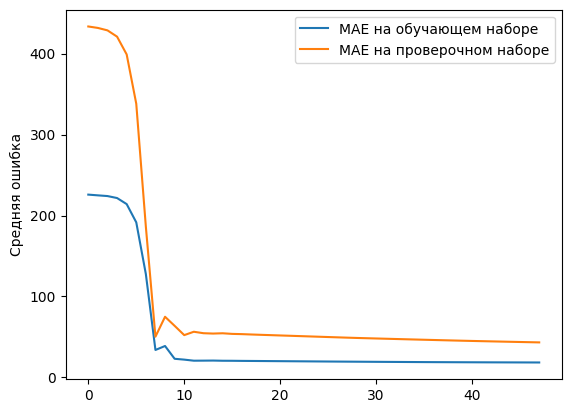

Epoch 1/8
13/13 [==============================] - 0s 28ms/step - loss: 563.0939 - mae: 18.3453 - val_loss: 3634.7329 - val_mae: 42.9523
Epoch 2/8
13/13 [==============================] - 0s 26ms/step - loss: 560.8119 - mae: 18.3131 - val_loss: 3601.9712 - val_mae: 42.7122
Epoch 3/8
13/13 [==============================] - 0s 28ms/step - loss: 558.5801 - mae: 18.2810 - val_loss: 3570.2810 - val_mae: 42.4753
Epoch 4/8
13/13 [==============================] - 0s 27ms/step - loss: 556.3978 - mae: 18.2489 - val_loss: 3539.6284 - val_mae: 42.2629
Epoch 5/8
13/13 [==============================] - 0s 27ms/step - loss: 554.2630 - mae: 18.2169 - val_loss: 3509.9758 - val_mae: 42.0640
Epoch 6/8
13/13 [==============================] - 0s 27ms/step - loss: 552.1749 - mae: 18.1849 - val_loss: 3481.2869 - val_mae: 41.8679
Epoch 7/8
13/13 [==============================] - 0s 27ms/step - loss: 550.1316 - mae: 18.1529 - val_loss: 3453.5322 - val_mae: 41.6744
Epoch 8/8
13/13 [========================

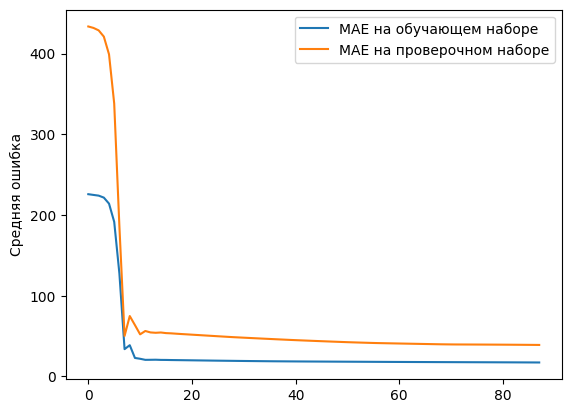

Epoch 1/8
13/13 [==============================] - 1s 59ms/step - loss: 492.7769 - mae: 17.2907 - val_loss: 2820.1274 - val_mae: 38.9858
Epoch 2/8
13/13 [==============================] - 1s 45ms/step - loss: 490.8336 - mae: 17.2574 - val_loss: 2804.2368 - val_mae: 38.9210
Epoch 3/8
13/13 [==============================] - 1s 50ms/step - loss: 488.8275 - mae: 17.2225 - val_loss: 2788.1687 - val_mae: 38.8521
Epoch 4/8
13/13 [==============================] - 0s 28ms/step - loss: 486.7523 - mae: 17.1862 - val_loss: 2771.8950 - val_mae: 38.7788
Epoch 5/8
13/13 [==============================] - 0s 28ms/step - loss: 484.6024 - mae: 17.1509 - val_loss: 2755.3840 - val_mae: 38.7009
Epoch 6/8
13/13 [==============================] - 0s 28ms/step - loss: 482.3708 - mae: 17.1145 - val_loss: 2738.6038 - val_mae: 38.6180
Epoch 7/8
13/13 [==============================] - 0s 28ms/step - loss: 480.0508 - mae: 17.0761 - val_loss: 2721.5247 - val_mae: 38.5299
Epoch 8/8
13/13 [========================

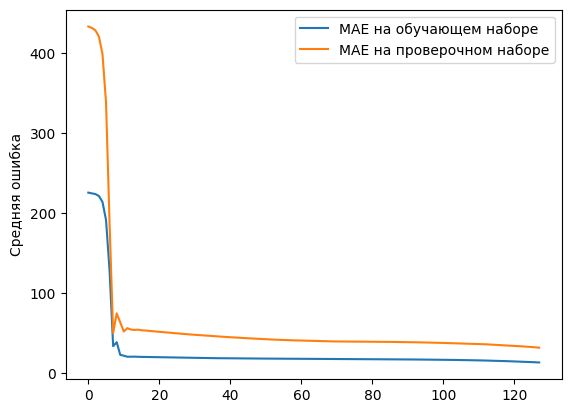

Epoch 1/8
13/13 [==============================] - 0s 27ms/step - loss: 274.3482 - mae: 13.2019 - val_loss: 1635.6935 - val_mae: 31.6467
Epoch 2/8
13/13 [==============================] - 0s 33ms/step - loss: 263.9577 - mae: 12.9672 - val_loss: 1586.5714 - val_mae: 31.2944
Epoch 3/8
13/13 [==============================] - 0s 30ms/step - loss: 253.6578 - mae: 12.7263 - val_loss: 1538.0767 - val_mae: 30.9278
Epoch 4/8
13/13 [==============================] - 0s 24ms/step - loss: 243.5215 - mae: 12.4890 - val_loss: 1490.5306 - val_mae: 30.5497
Epoch 5/8
13/13 [==============================] - 0s 33ms/step - loss: 233.6220 - mae: 12.2434 - val_loss: 1444.2423 - val_mae: 30.1546
Epoch 6/8
13/13 [==============================] - 0s 35ms/step - loss: 224.0299 - mae: 11.9909 - val_loss: 1399.4890 - val_mae: 29.7724
Epoch 7/8
13/13 [==============================] - 0s 29ms/step - loss: 214.8080 - mae: 11.7402 - val_loss: 1356.5281 - val_mae: 29.3895
Epoch 8/8
13/13 [========================

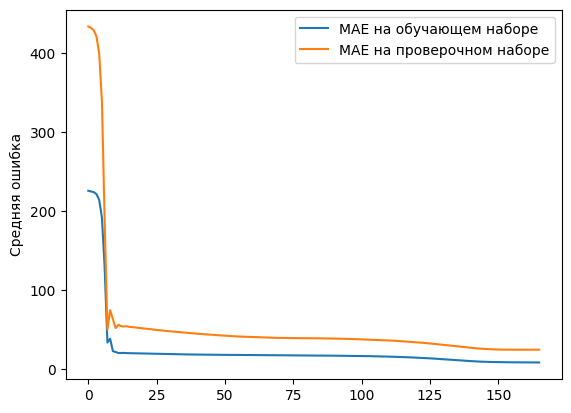

Epoch 1/8
13/13 [==============================] - 0s 30ms/step - loss: 121.0188 - mae: 8.6159 - val_loss: 897.9402 - val_mae: 24.8645
Epoch 2/8
13/13 [==============================] - 0s 37ms/step - loss: 120.5267 - mae: 8.5976 - val_loss: 897.3448 - val_mae: 24.8760
Epoch 3/8
13/13 [==============================] - 1s 38ms/step - loss: 120.0463 - mae: 8.5808 - val_loss: 896.9795 - val_mae: 24.8879
Epoch 4/8
13/13 [==============================] - 0s 29ms/step - loss: 119.5745 - mae: 8.5644 - val_loss: 896.8326 - val_mae: 24.9112
Epoch 5/8
13/13 [==============================] - 0s 28ms/step - loss: 119.1106 - mae: 8.5484 - val_loss: 896.8947 - val_mae: 24.9492
Epoch 6/8
13/13 [==============================] - 1s 41ms/step - loss: 118.6539 - mae: 8.5321 - val_loss: 897.1442 - val_mae: 24.9867
Epoch 1/8
13/13 [==============================] - 1s 42ms/step - loss: 118.2029 - mae: 8.5156 - val_loss: 897.5794 - val_mae: 25.0241
Epoch 2/8
13/13 [==============================] - 1s 4

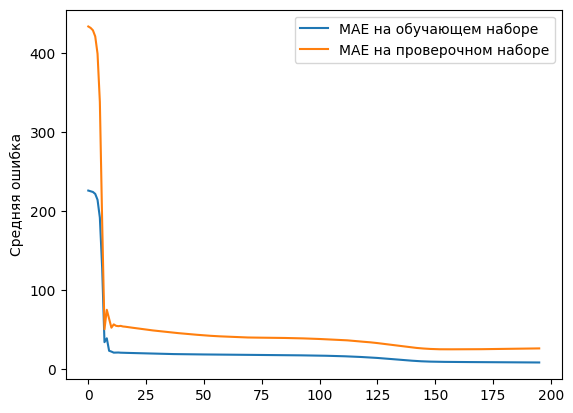

In [57]:
for iteration in range(num_iterations):
  history_3 = model_3.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_3.extend(history_3.history['val_mae'][:])
  hist_train_3.extend(history_3.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_3, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_3, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [58]:
pred_3 = model_3.predict(dataset_train).flatten()
pred_val_3 = model_3.predict(dataset_val).flatten()

5/5 [==============================] - 0s 3ms/step


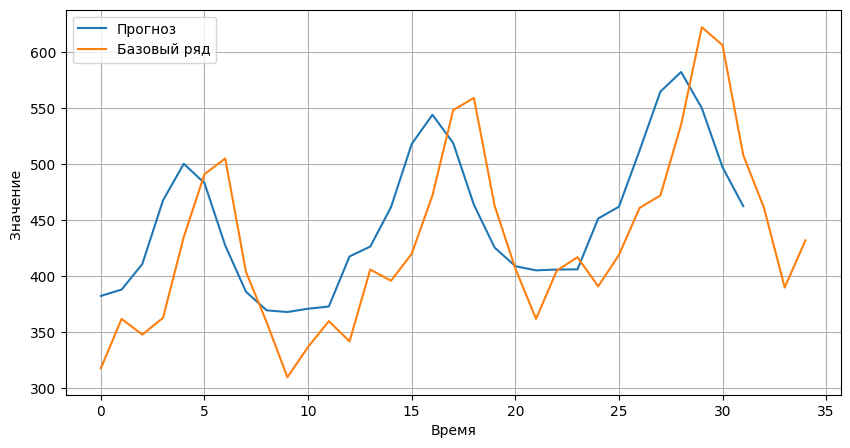

In [59]:
start = 0
step = 50
plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_val_3[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

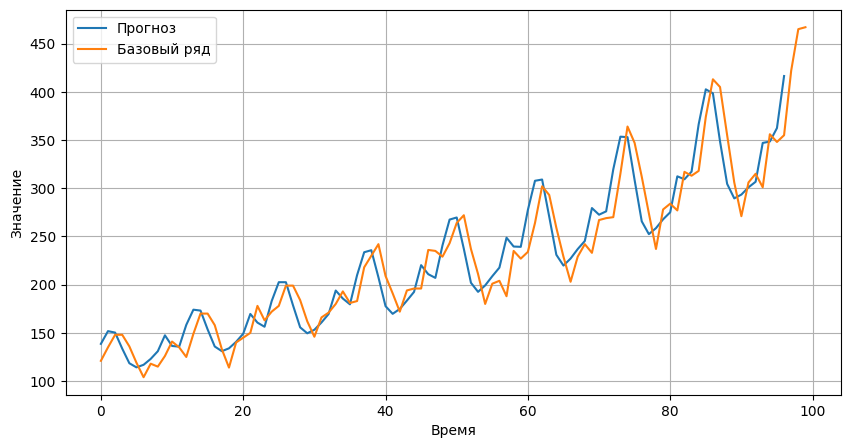

In [60]:
start = 0

plt.figure(figsize=(10, 5))
plt.grid('on')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [61]:
train_loss_3, train_m_3 = model_3.evaluate(dataset_train)
test_loss_3, test_m_3 = model_3.evaluate(dataset_val)
print(f'train_loss: {train_loss_3}, train_m: {train_m_3}')
print(f'test_loss: {test_loss_3}, test_m: {test_m_3}')

model.append('GRU')
train_m.append(round(train_m_3,2))
test_m.append(round(test_m_3,2))

5/5 [==============================] - 0s 6ms/step - loss: 944.8814 - mae: 25.9382
train_loss: 92.17498779296875, train_m: 7.584425926208496
test_loss: 944.8814086914062, test_m: 25.938228607177734


In [62]:
results['model'] = model
results['train_m'] = train_m
results['test_m'] = test_m

In [63]:
results

,model,train_m,test_m
0,SimpleRNN,7.53,30.42
1,LSTM,7.85,25.67
2,GRU,7.58,25.94


Выводы :

Реальной разницы между LSTM и GRU нет . GRU использует меньше параметров и соответственно меньше памяти а LSTM более точен . 